# Matrix Factorization with Bias

Similar to 09_matrix_factorization.py, but with user and item bias (TODO: Add reference on why this bias is needed).

## Reference:
- https://github.com/GabrielSandoval/matrix_factorization/blob/master/lib/mf.py
- https://d2l.ai/chapter_recommender-systems/mf.html
- https://medium.com/@maxbrenner-ai/matrix-factorization-for-collaborative-filtering-linear-to-non-linear-models-in-python-5cf54363a03c
- https://github.com/NicolasHug/Surprise/blob/master/surprise/prediction_algorithms/matrix_factorization.pyx
- https://everdark.github.io/k9/notebooks/ml/matrix_factorization/matrix_factorization.nb.html#3_neural_netork_representation

Consider the following matrix of ratings. The rows are the users, while the columns are the items, and the values are the rating 1-5.
In the first row, we see that user rated 5 for the item.

The average rating for this matrix is 2.8 stars (after rounding).

In [27]:
import numpy as np

ratings = np.array(
    [[5, 3, 0, 1], [4, 0, 0, 1], [1, 1, 0, 5], [1, 0, 0, 4], [0, 1, 5, 4]], dtype=float
)
avg_rating = np.mean(ratings[ratings.nonzero()])
np.round(avg_rating, 1)

2.8

We want to learn the bias of the user and the items. In the context of movie recommendation, the user bias can be a user that is picky about a user, and hence gives a lower rating (-0.5) than usual. However, the movie seems to have a of fans giving high rating (1.7).

The final rating after taking into consideration the initial average rating, the user bias and the item bias is:

```
final_rating = 2.8 - 0.5 + 1.7
             = 4.0
```


## Baseline Model

In the baseline model, we cover only the user and item biases.

In [28]:
import matplotlib.pyplot as plt
import numpy as np

In [81]:
# Assume we have some ratings matrix R
R = np.array(
    [[5, 3, 0, 1], [4, 0, 0, 1], [1, 1, 0, 5], [1, 0, 0, 4], [0, 1, 5, 4]],
    dtype=np.float32,
)

# Initialize user and item embedding matrices
num_users, num_items = R.shape

# Initialize user and item bias vectors
user_bias = np.zeros(num_users)
item_bias = np.zeros(num_items)

# Initialize average rating.
avg_rating = R[R.nonzero()].mean()

# Define the learning rate and regularization strength
lr = 0.01
reg_strength = 1e-5
losses = []
mask = R > 0
known_ratings = np.sum(mask)
tol = 1e-3

# Define the loss function
# NOTE: This is probably not the same as the evaluation function.
# We want to minimize this, by using the gradient.
# For errors however, we can just use anything, like MSE, SSE etc.
def sse(avg_rating, user_bias, item_bias):
    R_hat = avg_rating + user_bias[:, None] + item_bias[None, :]

    loss = np.square(R - R_hat)[mask].sum() + reg_strength * (
        np.square(user_bias).sum()
        + np.square(item_bias).sum()
        + np.square(U).sum()
        + np.square(V).sum()
    )
    return loss


def mse(avg_rating, user_bias, item_bias):
    R_hat = avg_rating + user_bias[:, None] + item_bias[None, :]
    return np.square(R - R_hat)[mask].sum() / known_ratings


T = 500
# Run the optimization
for t in range(T):
    for u, i in zip(*R.nonzero()):
        b_u = user_bias[u]
        b_i = item_bias[i]
        R_hat = avg_rating + b_u + b_i
        err = R[u, i] - R_hat

        # Update parameters
        user_bias[u] += lr * (err - reg_strength * b_u)
        item_bias[i] += lr * (err - reg_strength * b_i)
    loss = mse(avg_rating, user_bias, item_bias)
    losses.append(loss)
    if loss < tol:
        print(f"Terminating after {t} iterations, loss={loss}")
        break

0.02230769157409668
0.002084612427586555
-0.01793623390515055
0.012084614658355712
-0.017633793466289144
-0.018036231465920153
-0.01753279045420453
0.023019085569501364
-0.017855869116868647
0.012611761414457513
-0.01753782664782399
0.022483071594357584
0.01225763038487244
0.022258128244083776
0.0023504067483800795
-0.01812614213722135
0.012155600643256617
-0.017700296456240227
-0.017895947061365793
-0.017081490647269694
0.02301804986823348
-0.017790046562353258
0.012542934746303618
-0.01738716809329653
0.022084703821739115
0.011968155274682138
0.02220602639873342
0.002607285588364056
-0.018310041511838723
0.012224291897996231
-0.01776072387169726
-0.01776379515320986
-0.016644603539060013
0.023017370778018176
-0.01772633959404631
0.012480192409381854
-0.017239581994849467
0.021695722353845658
0.011689961212186427
0.022151591303529578
0.002855565355652746
-0.018488180861157427
0.012290799374641167
-0.017815410209955175
-0.017639406202044104
-0.01622165009219107
0.023016969467119088
-0.

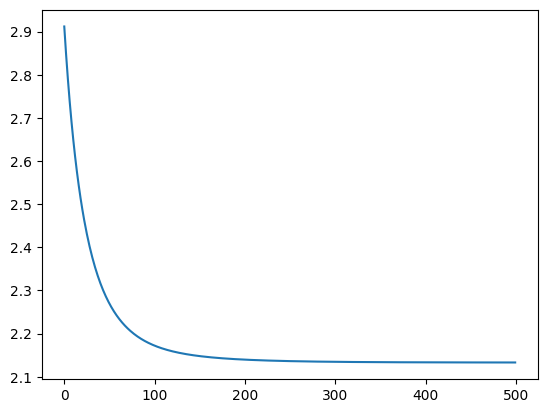

In [72]:
plt.plot(losses)

In [73]:
print("Original ratings:")
print(R)

Original ratings:
[[5. 3. 0. 1.]
 [4. 0. 0. 1.]
 [1. 1. 0. 5.]
 [1. 0. 0. 4.]
 [0. 1. 5. 4.]]


### Reconstructed Ratings

In [74]:
print("Reconstructed ratings:")
R_hat = avg_rating + user_bias[:, None] + item_bias[None, :]
print(np.round(R_hat, 2))

Reconstructed ratings:
[[3.39 1.96 5.23 3.6 ]
 [2.39 0.96 4.23 2.59]
 [2.76 1.32 4.59 2.96]
 [2.4  0.97 4.24 2.61]
 [3.14 1.7  4.98 3.34]]


In [49]:
sse_loss(avg_rating, user_bias, item_bias)

2.133126894011934

## SVD

See formula here:

https://github.com/recommenders-team/recommenders/blob/main/examples/02_model_collaborative_filtering/surprise_svd_deep_dive.ipynb

In [77]:
# Assume we have some ratings matrix R
R = np.array(
    [[5, 3, 0, 1], [4, 0, 0, 1], [1, 1, 0, 5], [1, 0, 0, 4], [0, 1, 5, 4]],
    dtype=np.float32,
)

# Initialize user and item embedding matrices
num_users, num_items = R.shape
embedding_dim = 10
U = np.random.normal(size=(num_users, embedding_dim))
V = np.random.normal(size=(num_items, embedding_dim))
non_zero_mask = R > 0
known_ratings = np.sum(non_zero_mask)

# Initialize user and item bias vectors
user_bias = np.zeros(num_users)
item_bias = np.zeros(num_items)

# Initialize average rating.
avg_rating = R[R.nonzero()].mean()

# Define the learning rate and regularization strength
lr = 0.01
reg_strength = 1e-5
tol = 1e-3
losses = []

mask = R > 0
# We take into considerating the known ratings only when calculating errors.
known_ratings = np.sum(mask)

# Define the loss function
# NOTE: this is the loss function, but for evaluation we can just use the MSE.
# This loss function is converted into gradient calculation to minimize the loss.
def sse_loss(U, V, user_bias, item_bias, avg_rating, R):
    R_hat = U @ V.T + user_bias[:, None] + item_bias[None, :] + avg_rating

    # Squared sum error (SSE) of known ratings.
    loss = np.sum(np.square((R - R_hat)[non_zero_mask]))
    # Add regularization
    loss += reg_strength * (
        np.sum([np.square(v).sum() for v in [U, V, user_bias, item_bias]])
    )
    return loss


# Run the optimization
for t in range(500):
    for u, i in zip(*R.nonzero()):
        b_u = user_bias[u]
        b_i = item_bias[i]
        R_hat = U[u] @ V[i].T + b_u + b_i + avg_rating
        err = R[u, i] - R_hat

        # Compute gradients
        grad_U = err * V[i] - reg_strength * U[u]
        grad_V = err * U[u] - reg_strength * V[i]
        grad_user_bias = err - reg_strength * b_u
        grad_item_bias = err - reg_strength * b_i

        # Update parameters
        U[u] += lr * grad_U
        V[i] += lr * grad_V
        user_bias[u] += lr * grad_user_bias
        item_bias[i] += lr * grad_item_bias

    loss = sse_loss(U, V, user_bias, item_bias, avg_rating, R)
    if i % 100 == 0:
        print("Iteration", i, "Loss", loss)
    losses.append(loss)
    if loss < tol:
        print(f"Terminating after {t} iterations, loss={loss}")
        break

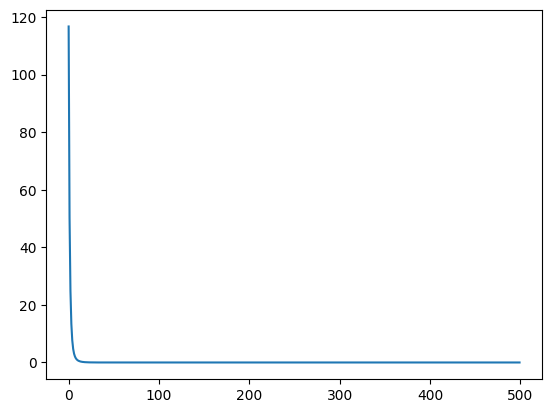

In [78]:
plt.plot(losses)

In [79]:
print("Original ratings:")
print(R)

Original ratings:
[[5. 3. 0. 1.]
 [4. 0. 0. 1.]
 [1. 1. 0. 5.]
 [1. 0. 0. 4.]
 [0. 1. 5. 4.]]


### Reconstructed Ratings

In [80]:
print("Reconstructed ratings:")
R_hat = U @ V.T + user_bias[:, None] + item_bias[None, :] + avg_rating
print(np.round(R_hat, 2))

Reconstructed ratings:
[[ 5.    3.    2.25  1.  ]
 [ 4.    3.8  -4.63  1.  ]
 [ 1.    1.    5.24  5.  ]
 [ 1.   10.37 -6.57  4.  ]
 [ 5.9   1.    5.    4.  ]]


In [62]:
sse_loss(U, V, user_bias, item_bias, avg_rating, R)

0.0009628049799044417

### Output

In [64]:
# If the replace does not work, check if the data type for R matches R_hat, which is float.
# If the data type of the matrix to replace does not match, it will silently failed.
mask = R == 0
R[mask] = R_hat[mask]
np.round(np.clip(R, 0, 5), 1)

array([[5. , 3. , 2. , 1. ],
       [4. , 1.3, 4. , 1. ],
       [1. , 1. , 5. , 5. ],
       [1. , 2.5, 4. , 4. ],
       [5. , 1. , 5. , 4. ]], dtype=float32)

In [23]:
R_hat = (
    U.numpy() @ V.numpy().T
    + avg_rating.numpy()
    + user_bias.numpy()[:, None]
    + item_bias.numpy()[None, :]
)
np.round(R_hat, 2)

array([[ 5.  ,  3.  ,  2.09,  1.  ],
       [ 4.  , -7.36,  6.09,  1.  ],
       [ 1.  ,  1.  ,  4.27,  5.  ],
       [ 1.  ,  1.59,  3.13,  4.  ],
       [ 3.89,  1.  ,  5.  ,  4.  ]], dtype=float32)